<a href="https://colab.research.google.com/github/NOUTAILAA/ODIR-5KK/blob/main/ODIR_5K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ocular Disease Recognition (ODIR-5K)

ODIR-5K est un dataset très connu en ophtalmologie, contenant 5 000 patients classés dans 8 catégories médicales (annotations faites par des médecins).

Les 8 catégories sont :

Code	Maladie	Explication
N	Normal	Aucun problème détecté

D	Diabetic Retinopathy	Rétinopathie diabétique

G	Glaucoma	Pression oculaire élevée → nerf optique ---- (TENSION DIAL L 'oeil)

C	Cataract	Opacification du cristallin ( JLALA )

A	AMD – Dégénérescence Maculaire	Perte de vision centrale

H	Hypertension	Dommages rétiniens liés à une tension élevée ( Une personne tl3at liha tension o 9aset liha la rétine )

M	Myopia	Myopie sévère avec déformations du fond d’œil

O	Other	Autres anomalies (hémorragies, infections, etc.)

In [ ]:
import kagglehub, os, pandas as pd

path = kagglehub.dataset_download("andrewmvd/ocular-disease-recognition-odir5k")
print("Dataset root:", path)

root = os.path.join(path, "ODIR-5K", "ODIR-5K")  # ⚠️ double ODIR-5K

train_img_dir = os.path.join(root, "Training Images")
test_img_dir  = os.path.join(root, "Testing Images")
excel_path    = os.path.join(root, "data.xlsx")

print("Train path:", train_img_dir)
print("Excel path:", excel_path)

df = pd.read_excel(excel_path)

print(df.columns)


Using Colab cache for faster access to the 'ocular-disease-recognition-odir5k' dataset.
Dataset root: /kaggle/input/ocular-disease-recognition-odir5k
Train path: /kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images
Excel path: /kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/data.xlsx
Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O'],
      dtype='object')


In [ ]:
import kagglehub
import os

# Télécharger le dataset
dataset_path = kagglehub.dataset_download("andrewmvd/ocular-disease-recognition-odir5k")

print("Dataset path:", dataset_path)

# Afficher les fichiers et dossiers à la racine
print("\n📁 Contenu du dataset :")
for item in os.listdir(dataset_path):
    print(" -", item)

# Afficher les sous-dossiers en profondeur
print("\n📂 Sous-dossiers :")
for root, dirs, files in os.walk(dataset_path):
    print(f"\n📌 Dossier : {root}")
    for d in dirs:
        print("   📁", d)
    for f in files:
        print("   📄", f)


100%|██████████| 1.62G/1.62G [00:55<00:00, 31.3MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2

📁 Contenu du dataset :
 - preprocessed_images
 - full_df.csv
 - ODIR-5K

📂 Sous-dossiers :

📌 Dossier : /root/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2
   📁 preprocessed_images
   📁 ODIR-5K
   📄 full_df.csv

📌 Dossier : /root/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2/preprocessed_images
   📄 4212_left.jpg
   📄 4156_left.jpg
   📄 133_left.jpg
   📄 2827_right.jpg
   📄 2967_left.jpg
   📄 2841_left.jpg
   📄 93_right.jpg
   📄 1050_right.jpg
   📄 1606_left.jpg
   📄 2811_right.jpg
   📄 4_left.jpg
   📄 2251_right.jpg
   📄 1546_left.jpg
   📄 4456_left.jpg
   📄 3423_right.jpg
   📄 3301_right.jpg
   📄 570_right.jpg
   📄 459_left.jpg
   📄 1364_right.jpg
   📄 3296_left.jpg
   📄 4285_right.jpg
   📄 976_right.jpg
   📄 1489_right.jpg
   📄 1629_right.jpg
   📄 542_right.jpg
   📄 1985_right.jpg
   📄 3312_right.jpg
   📄 2248_lef

In [ ]:
import numpy as np

records = []

for _, row in df.iterrows():
    for side, col in [("left", "Left-Fundus"), ("right", "Right-Fundus")]:
        img_name = row[col]
        if pd.isna(img_name):
            continue

        img_path = os.path.join(train_img_dir, img_name)

        # Sécurité : on vérifie que le fichier existe
        if not os.path.exists(img_path):
            print("❌ Fichier introuvable:", img_path)
            continue

        records.append({
            "img_path": img_path,
            "side": side,
            "age": row["Patient Age"],
            "sex": row["Patient Sex"],
            "N": row["N"],
            "D": row["D"],
            "G": row["G"],
            "C": row["C"],
            "A": row["A"],
            "H": row["H"],
            "M": row["M"],
            "O": row["O"],
        })

df_img = pd.DataFrame(records)
print(len(df_img), "images au total")


7000 images au total


In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df_img,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

train_dataset = ODIRDataset(train_df, transform=train_tfms)
val_dataset   = ODIRDataset(val_df,   transform=val_tfms)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=2)


2. Dataset PyTorch

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

img_size = 224

train_tfms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

val_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

class ODIRDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["img_path"]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        labels = torch.tensor(
            row[["N","D","G","C","A","H","M","O"]].values.astype("float32")
        )

        return image, labels


In [ ]:
from torch.utils.data import DataLoader

batch_size = 16

train_dataset = ODIRDataset(train_df, transform=train_tfms)
val_dataset   = ODIRDataset(val_df,   transform=val_tfms)

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=2)


3. Modèle CNN (ResNet18 fine-tuné, multi-label)

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet18 pré-entraîné
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)   # 8 labels: N,D,G,C,A,H,M,O
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()  # multi-label
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)


@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)


num_epochs = 10

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss   = eval_one_epoch(model,   val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs} - train_loss={train_loss:.4f} val_loss={val_loss:.4f}")


Epoch 1/10 - train_loss=0.3363 val_loss=0.2874
Epoch 2/10 - train_loss=0.2826 val_loss=0.2792
Epoch 3/10 - train_loss=0.2674 val_loss=0.2784
Epoch 4/10 - train_loss=0.2571 val_loss=0.2831
Epoch 5/10 - train_loss=0.2444 val_loss=0.2939
Epoch 6/10 - train_loss=0.2323 val_loss=0.2831
Epoch 7/10 - train_loss=0.2179 val_loss=0.2957
Epoch 8/10 - train_loss=0.2033 val_loss=0.3108
Epoch 9/10 - train_loss=0.1891 val_loss=0.3034
Epoch 10/10 - train_loss=0.1697 val_loss=0.3274


5. Prédiction & seuil

In [ ]:
import torch

model.eval()
images, labels = next(iter(val_loader))
images = images.to(device)
with torch.no_grad():
    logits = model(images)
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).int()

print("Probabilités d’un batch:", probs[0])
print("Labels vrais:", labels[0])
print("Prédiction binaire:", preds[0])


Probabilités d’un batch: tensor([4.4657e-02, 8.7764e-01, 2.0944e-02, 1.0531e-02, 3.5751e-03, 2.1307e-01,
        6.1765e-04, 2.5358e-01])
Labels vrais: tensor([0., 1., 0., 0., 0., 0., 0., 0.])
Prédiction binaire: tensor([0, 1, 0, 0, 0, 0, 0, 0], dtype=torch.int32)


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

label_names = ["N","D","G","C","A","H","M","O"]

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        logits = model(images)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)
        all_labels.append(labels.numpy())

all_probs = np.concatenate(all_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print("Shape probs:", all_probs.shape)
print("Shape labels:", all_labels.shape)


Shape probs: (1400, 8)
Shape labels: (1400, 8)


🔹 Accuracy par label

In [ ]:
preds = (all_probs > 0.5).astype(np.float32)

for i, name in enumerate(label_names):
    acc = (preds[:, i] == all_labels[:, i]).mean()
    print(f"{name} - accuracy: {acc:.3f}")


N - accuracy: 0.686
D - accuracy: 0.731
G - accuracy: 0.939
C - accuracy: 0.964
A - accuracy: 0.964
H - accuracy: 0.958
M - accuracy: 0.984
O - accuracy: 0.716


🔹 AUC par label

In [ ]:
for i, name in enumerate(label_names):
    y_true = all_labels[:, i]
    y_score = all_probs[:, i]

    # S’il n’y a que des 0 ou que des 1, roc_auc_score plante
    if len(np.unique(y_true)) < 2:
        print(f"{name} - AUC: impossible (une seule classe présente)")
        continue

    auc = roc_auc_score(y_true, y_score)
    print(f"{name} - AUC: {auc:.3f}")


N - AUC: 0.738
D - AUC: 0.754
G - AUC: 0.845
C - AUC: 0.932
A - AUC: 0.814
H - AUC: 0.808
M - AUC: 0.953
O - AUC: 0.686


In [ ]:
from PIL import Image

# On prend une ligne de val_df
row = val_df.iloc[0]
img_path = row["img_path"]
print("Image:", img_path)

# Charger l’image
img = Image.open(img_path).convert("RGB")

# Même transform que validation
input_tensor = val_tfms(img).unsqueeze(0).to(device)  # shape: (1, 3, H, W)

model.eval()
with torch.no_grad():
    logits = model(input_tensor)
    probs = torch.sigmoid(logits).cpu().numpy()[0]
    preds = (probs > 0.5).astype(int)

print("Labels vrais:")
for name in label_names:
    print(f"  {name}: {row[name]}")

print("\nPrédictions du modèle:")
for name, p, b in zip(label_names, probs, preds):
    print(f"  {name}: p={p:.3f}  ->  pred={b}")


Image: /kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/4400_left.jpg
Labels vrais:
  N: 0
  D: 1
  G: 0
  C: 0
  A: 0
  H: 0
  M: 0
  O: 0

Prédictions du modèle:
  N: p=0.045  ->  pred=0
  D: p=0.878  ->  pred=1
  G: p=0.021  ->  pred=0
  C: p=0.011  ->  pred=0
  A: p=0.004  ->  pred=0
  H: p=0.213  ->  pred=0
  M: p=0.001  ->  pred=0
  O: p=0.254  ->  pred=0


**Cas d'oeil DIABETE**

Saving fundusimage.png to fundusimage.png
Image uploadée : fundusimage.png


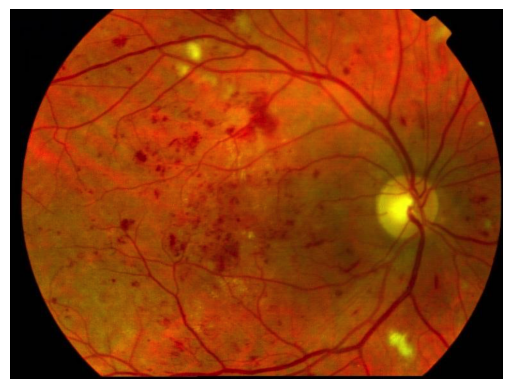


🔍 Résultats du modèle sur l'image uploadée :

N: p=0.024 → pred=0
D: p=0.808 → pred=1
G: p=0.474 → pred=0
C: p=0.002 → pred=0
A: p=0.002 → pred=0
H: p=0.053 → pred=0
M: p=0.002 → pred=0
O: p=0.514 → pred=1


In [ ]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# 1️⃣ Upload de l’image
uploaded = files.upload()

# Récupérer le nom du fichier uploadé
external_path = list(uploaded.keys())[0]
print("Image uploadée :", external_path)

# 2️⃣ Charger et afficher l’image
img = Image.open(external_path).convert("RGB")

plt.imshow(img)
plt.axis("off")
plt.show()

# 3️⃣ Préparer l’image pour le modèle
input_tensor = val_tfms(img).unsqueeze(0).to(device)

# 4️⃣ Prédiction
model.eval()
with torch.no_grad():
    logits = model(input_tensor)
    probs = torch.sigmoid(logits).cpu().numpy()[0]
    preds = (probs > 0.5).astype(int)

# 5️⃣ Afficher résultat formaté
label_names = ["N","D","G","C","A","H","M","O"]

print("\n🔍 Résultats du modèle sur l'image uploadée :\n")
for name, p, b in zip(label_names, probs, preds):
    print(f"{name}: p={p:.3f} → pred={b}")


Image sélectionnée : /kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/2394_left.jpg


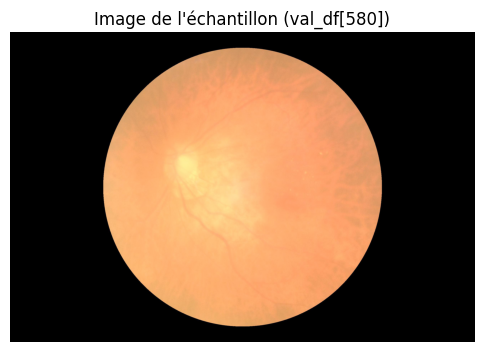


Labels vrais:
  N: 1
  D: 0
  G: 0
  C: 0
  A: 0
  H: 0
  M: 0
  O: 0

Prédictions du modèle:
  N: p=0.006  ->  pred=0
  D: p=0.082  ->  pred=0
  G: p=0.007  ->  pred=0
  C: p=0.963  ->  pred=1
  A: p=0.020  ->  pred=0
  H: p=0.003  ->  pred=0
  M: p=0.020  ->  pred=0
  O: p=0.474  ->  pred=0


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

#CHOISIR L'image !!!!!!! ligne 580 par exemplerow = val_df.iloc[580]
img_path = row["img_path"]
print("Image sélectionnée :", img_path)

# 🟢 CHARGER L’IMAGE
img = Image.open(img_path).convert("RGB")

# 🖼️ AFFICHER L’IMAGE
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title("Image de l'échantillon (val_df[580])")
plt.axis("off")
plt.show()

# 🟠 TRANSFORMER L’IMAGE AVANT PREDICTION
input_tensor = val_tfms(img).unsqueeze(0).to(device)

# 🔴 PREDICTION
model.eval()
with torch.no_grad():
    logits = model(input_tensor)
    probs = torch.sigmoid(logits).cpu().numpy()[0]
    preds = (probs > 0.5).astype(int)

# 📌 AFFICHAGE DES LABELS
print("\nLabels vrais:")
for name in label_names:
    print(f"  {name}: {row[name]}")

print("\nPrédictions du modèle:")
for name, p, b in zip(label_names, probs, preds):
    print(f"  {name}: p={p:.3f}  ->  pred={b}")


**Cas d'oeil NORMAL**

Saving nomalade.jpg to nomalade.jpg
Image uploadée : nomalade.jpg


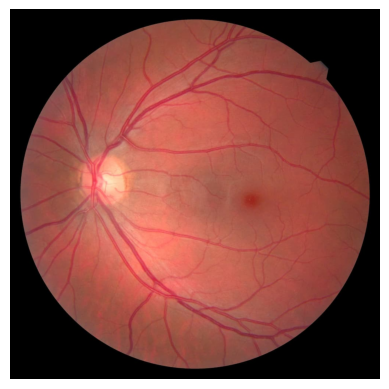


🔍 Résultats du modèle sur l'image uploadée :

N: p=0.777 → pred=1
D: p=0.141 → pred=0
G: p=0.001 → pred=0
C: p=0.012 → pred=0
A: p=0.002 → pred=0
H: p=0.007 → pred=0
M: p=0.001 → pred=0
O: p=0.021 → pred=0


In [ ]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# 1️⃣ Upload de l’image
uploaded = files.upload()

# Récupérer le nom du fichier uploadé
external_path = list(uploaded.keys())[0]
print("Image uploadée :", external_path)

# 2️⃣ Charger et afficher l’image
img = Image.open(external_path).convert("RGB")

plt.imshow(img)
plt.axis("off")
plt.show()

# 3️⃣ Préparer l’image pour le modèle
input_tensor = val_tfms(img).unsqueeze(0).to(device)

# 4️⃣ Prédiction
model.eval()
with torch.no_grad():
    logits = model(input_tensor)
    probs = torch.sigmoid(logits).cpu().numpy()[0]
    preds = (probs > 0.5).astype(int)

# 5️⃣ Afficher résultat formaté
label_names = ["N","D","G","C","A","H","M","O"]

print("\n🔍 Résultats du modèle sur l'image uploadée :\n")
for name, p, b in zip(label_names, probs, preds):
    print(f"{name}: p={p:.3f} → pred={b}")
